In [1]:
import os
import sys
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import warnings
from scipy.stats import randint
from tqdm import tqdm
from xgboost import XGBRegressor
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split, RandomizedSearchCV, KFold, cross_val_score
from sklearn.datasets import make_regression
from sklearn.ensemble import RandomForestRegressor as rf
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error, r2_score

In [2]:
os.chdir('C:\\Users\\omkarp\\Downloads\\Python\\Stockholm\\')
data = pd.read_csv('Data.csv')
data = data.drop(columns=['mean_distance', 'mean_time'])
data = data.dropna()
data = data.reset_index(drop=True)
# Convert 'day' and 'month' columns to categorical
data['day'] = data['day'].astype('category')
data['month'] = data['month'].astype('category')
# Encode 'FID_grid' as a categorical variable
le = LabelEncoder()
data['encOrigin'] = le.fit_transform(data['FID_grid'])
data['day'] = le.fit_transform(data['day'])
data['month'] = le.fit_transform(data['month'])
data

,FID_grid,day,month,count_trips,M19,F19,MEmpl,FEmpl,Empl,Pop22,...,LUP_Other,T_Other,AreaProx,Rd_Resi,Rd_Arte,Rd_Comml,Rd_Cyc,Rd_Pedes,Rd_Other,encOrigin
0,10,6,4,8,436.0,451.0,404.0,404.0,809.0,887.0,...,0.0,0.0,660104.976827,1493.721609,1493.721609,1493.721609,1493.721609,1493.721609,1493.721609,0
1,10,5,4,6,436.0,451.0,404.0,404.0,809.0,887.0,...,0.0,0.0,660104.976827,1493.721609,1493.721609,1493.721609,1493.721609,1493.721609,1493.721609,0
2,10,2,4,14,436.0,451.0,404.0,404.0,809.0,887.0,...,0.0,0.0,660104.976827,1493.721609,1493.721609,1493.721609,1493.721609,1493.721609,1493.721609,0
3,10,0,4,7,436.0,451.0,404.0,404.0,809.0,887.0,...,0.0,0.0,660104.976827,1493.721609,1493.721609,1493.721609,1493.721609,1493.721609,1493.721609,0
4,10,4,4,8,436.0,451.0,404.0,404.0,809.0,887.0,...,0.0,0.0,660104.976827,1493.721609,1493.721609,1493.721609,1493.721609,1493.721609,1493.721609,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23679,897,2,5,27,252.0,257.0,238.0,242.0,479.0,509.0,...,0.0,0.0,934415.974984,289.766536,289.766536,289.766536,289.766536,289.766536,289.766536,467
23680,897,2,11,23,252.0,257.0,238.0,242.0,479.0,509.0,...,0.0,0.0,934415.974984,289.766536,289.766536,289.766536,289.766536,289.766536,289.766536,467
23681,897,3,1,33,252.0,257.0,238.0,242.0,479.0,509.0,...,0.0,0.0,934415.974984,289.766536,289.766536,289.766536,289.766536,289.766536,289.766536,467
23682,897,3,5,33,252.0,257.0,238.0,242.0,479.0,509.0,...,0.0,0.0,934415.974984,289.766536,289.766536,289.766536,289.766536,289.766536,289.766536,467


# Feature Selection

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23684 entries, 0 to 23683
Data columns (total 30 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   FID_grid     23684 non-null  int64  
 1   day          23684 non-null  int32  
 2   month        23684 non-null  int32  
 3   count_trips  23684 non-null  int64  
 4   M19          23684 non-null  float64
 5   F19          23684 non-null  float64
 6   MEmpl        23684 non-null  float64
 7   FEmpl        23684 non-null  float64
 8   Empl         23684 non-null  float64
 9   Pop22        23684 non-null  float64
 10  Inc          23684 non-null  float64
 11  Veh          23684 non-null  float64
 12  LUP_Resi     23684 non-null  float64
 13  LUP_Comm     23684 non-null  float64
 14  LUP_Edu      23684 non-null  float64
 15  LUP_Recre    23684 non-null  float64
 16  LUP_Public   23684 non-null  float64
 17  LUP_Health   23684 non-null  float64
 18  T_Enable     23684 non-null  float64
 19  T_Hi

In [4]:
data.columns

Index(['FID_grid', 'day', 'month', 'count_trips', 'M19', 'F19', 'MEmpl',
       'FEmpl', 'Empl', 'Pop22', 'Inc', 'Veh', 'LUP_Resi', 'LUP_Comm',
       'LUP_Edu', 'LUP_Recre', 'LUP_Public', 'LUP_Health', 'T_Enable',
       'T_Hinder', 'LUP_Other', 'T_Other', 'AreaProx', 'Rd_Resi', 'Rd_Arte',
       'Rd_Comml', 'Rd_Cyc', 'Rd_Pedes', 'Rd_Other', 'encOrigin'],
      dtype='object')

98.83482519844621
42.0


<Axes: xlabel='count_trips', ylabel='Count'>

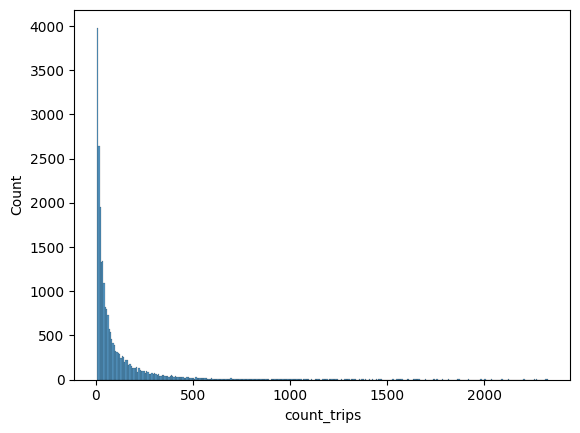

In [5]:
print(data['count_trips'].mean())
print(data['count_trips'].median())
sns.histplot(data['count_trips'])

## Feature Importance

25


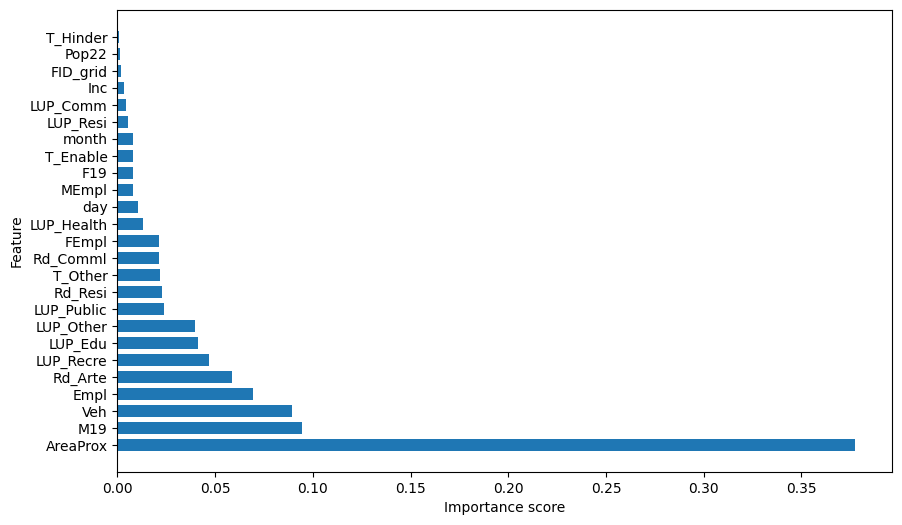

In [6]:
# Check feature Importance to eliminate features
categorical_cols = ['FID_grid', 'day', 'month']
# spatial_cols = ['x', 'y']
dependent_var = 'count_trips'
independent_cols = ['M19', 'F19', 'MEmpl', 'FEmpl', 'Empl', 'Pop22', 'Inc', 'Veh',
                 'LUP_Resi', 'LUP_Comm', 'LUP_Edu', 'LUP_Recre', 'LUP_Public','LUP_Health', 'T_Enable', 'T_Hinder',
                 'LUP_Other', 'T_Other','AreaProx', 'Rd_Resi', 'Rd_Arte', 'Rd_Comml', 'Rd_Cyc', 'Rd_Pedes','Rd_Other']

data = data[categorical_cols +  [dependent_var] + independent_cols]
data.reset_index(drop=True, inplace=True)
X = data.drop("count_trips", axis=1) # features
y = data["count_trips"] # target variable
# Generate feature importance
X, y = make_regression(n_samples=100, n_features=25, random_state=42)

# Train a spatial random forest model
xgb = XGBRegressor(n_estimators=100, max_depth=10, random_state=42)
xgb.fit(X, y)

# Calculate feature importance
feature_importance = xgb.feature_importances_
feature_names = ['FID_grid', 'day', 'month','M19', 'F19', 'MEmpl', 'FEmpl', 'Empl', 'Pop22', 'Inc', 'Veh',
                 'LUP_Resi', 'LUP_Comm', 'LUP_Edu', 'LUP_Recre', 'LUP_Public','LUP_Health', 'T_Enable', 'T_Hinder',
                 'LUP_Other', 'T_Other','AreaProx', 'Rd_Resi', 'Rd_Arte', 'Rd_Comml', 'Rd_Cyc', 'Rd_Pedes','Rd_Other']
# Create a dictionary with feature names and their corresponding importance scores
feature_importance_dict = dict(zip(feature_names, feature_importance))

# Sort the dictionary in descending order of importance scores
sorted_dict = dict(sorted(feature_importance_dict.items(), key=lambda x: x[1], reverse=True))

# Extract the feature names and importance scores in separate lists
sorted_feature_names = list(sorted_dict.keys())
sorted_feature_importance = list(sorted_dict.values())
print(len(sorted_feature_names))

plt.figure(figsize=(10,6))
plt.barh(y=range(len(sorted_feature_importance)), width=sorted_feature_importance, height=0.7, align='center')
plt.yticks(range(len(sorted_feature_names)), sorted_feature_names)
plt.xlabel('Importance score')
plt.ylabel('Feature')
plt.show()

## VIF (variance_inflation_factor)

In [7]:
sorted_feature_names.remove('Rd_Comml')
sorted_feature_names.remove('Rd_Resi')
features_test = sorted_feature_names
col_test = data[features_test]

# VIF dataframe
vif_data = pd.DataFrame()
vif_data["feature"] = col_test.columns
# calculating VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(col_test.values.astype(float), i)
                          for i in range(len(col_test.columns))]

vif_data = vif_data.sort_values(by="VIF", ascending=False)
print(vif_data.to_string(index=False, float_format='%.2f'))

   feature        VIF
     Pop22 7173388.27
      Empl 5903078.69
       F19 1809293.09
       M19 1784333.61
     FEmpl 1498335.40
     MEmpl 1462967.46
       Veh      57.31
       Inc       9.96
   Rd_Arte       5.20
  AreaProx       4.66
  FID_grid       4.62
     month       3.22
       day       2.82
  T_Enable       1.23
 LUP_Recre       1.23
  LUP_Resi       1.19
  LUP_Comm       1.16
  T_Hinder       1.15
LUP_Public       1.13
 LUP_Other       1.13
   LUP_Edu       1.10
   T_Other       1.07
LUP_Health       1.04


In [8]:
sorted_feature_names = vif_data[vif_data['VIF'] > 1.15]['feature']
print(len(sorted_feature_names))
sorted_feature_names=sorted_feature_names.tolist()
sorted_feature_names

17


['Pop22',
 'Empl',
 'F19',
 'M19',
 'FEmpl',
 'MEmpl',
 'Veh',
 'Inc',
 'Rd_Arte',
 'AreaProx',
 'FID_grid',
 'month',
 'day',
 'T_Enable',
 'LUP_Recre',
 'LUP_Resi',
 'LUP_Comm']

C:\Users\omkarp\AppData\Local\Temp\ipykernel_16172\4048142416.py:12: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.triu(np.ones_like(corr, dtype=np.bool))


[Text(0, 0.5, 'Pop22'),
 Text(0, 1.5, 'Rd_Arte'),
 Text(0, 2.5, 'AreaProx'),
 Text(0, 3.5, 'FID_grid'),
 Text(0, 4.5, 'month'),
 Text(0, 5.5, 'day'),
 Text(0, 6.5, 'T_Enable'),
 Text(0, 7.5, 'LUP_Recre'),
 Text(0, 8.5, 'LUP_Resi'),
 Text(0, 9.5, 'LUP_Comm')]

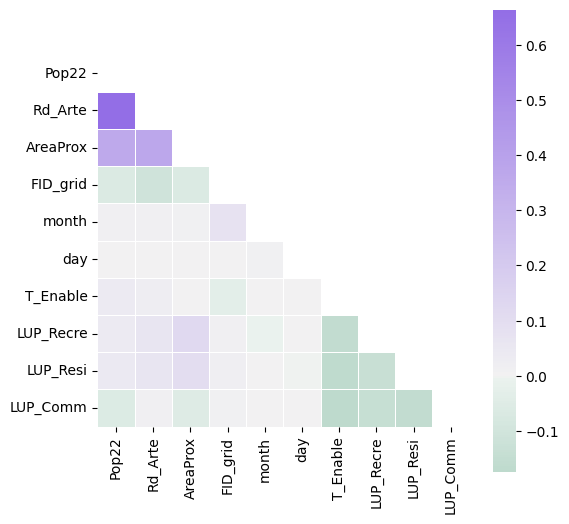

In [9]:
features_1 = sorted_feature_names
# Dropping all features that have a correlation higher than 60%
features_1.remove('M19')
features_1.remove('F19')
features_1.remove('MEmpl')
features_1.remove('FEmpl')
features_1.remove('Empl')
features_1.remove('Inc')
features_1.remove('Veh')

corr = data[features_1].corr('spearman')
mask = np.triu(np.ones_like(corr, dtype=np.bool))
f, ax = plt.subplots(figsize=(6, 6))
cmap = sns.diverging_palette(150, 275, s=80, l=55, n=9, as_cmap=True)
g = sns.heatmap(corr, mask=mask, cmap=cmap, vmax=None, center=0,square=True,linewidths=.5, cbar_kws={"shrink": 1})
g.set_xticklabels(g.get_xmajorticklabels(), fontsize = 10)
g.set_yticklabels(g.get_ymajorticklabels(), fontsize = 10)

In [10]:
print(len(features_1))
X = data[features_1].values
y = data['count_trips'].values
features_1

10


['Pop22',
 'Rd_Arte',
 'AreaProx',
 'FID_grid',
 'month',
 'day',
 'T_Enable',
 'LUP_Recre',
 'LUP_Resi',
 'LUP_Comm']

# XG-Boost Model

In [11]:
x_train, x_test, y_train, y_test=train_test_split(X, y, test_size=0.2)

In [12]:
model = None

# train the model
model = XGBRegressor(n_estimators=10, max_depth=20, verbosity=0)
model.fit(x_train, y_train)

# extract the training set predictions
model.predict(x_train)

array([112.87659 ,  75.34737 ,  34.133327, ...,  84.03876 ,  15.693939,
        48.62337 ], dtype=float32)

In [13]:
import xgboost as xgb
xgbr = xgb.XGBRegressor(verbosity=0) 
xgbr.fit(x_train, y_train)
score = xgbr.score(x_train, y_train)  
print("Training score: ", score)

scores = cross_val_score(xgbr, x_train, y_train,cv=10)
print("Mean cross-validation R2: %.2f" % scores.mean())

kfold = KFold(n_splits=10, shuffle=True)
kf_cv_scores = cross_val_score(xgbr, x_train, y_train, cv=kfold )
print("K-fold CV average score: %.2f" % kf_cv_scores.mean())

from sklearn.metrics import mean_squared_error
ypred = xgbr.predict(x_test)
mse = mean_squared_error(y_test, ypred)
print(f'mse: ', mse , '\nrmse: ',mse**(1/2) )

Training score:  0.9569032537172764
Mean cross-validation R2: 0.92
K-fold CV average score: 0.92
mse:  2175.6315953893154 
rmse:  46.643666187268295


## Hyperparameter optimisation

In [14]:
regressor=xgb.XGBRegressor(objective="reg:squarederror")
n_estimators = [50,100,500,900,1100,1500]
max_depth = [2,3,5,10,15, 20, 25]
booster = ['gbtree', 'gblinear']
learning_rate = [0.05, 0.1, 0.15, 0.2]
min_child_weight = [1,2,3,4,5]
base_score = [0.25,0.5,0.75,1]

hyperparameter_grid = {
    'n_estimators': n_estimators,
    'max_depth':max_depth,
    'learning_rate':learning_rate,
    'min_child_weight':min_child_weight,
    'booster':booster,
    'base_score':base_score
}

random_cv= RandomizedSearchCV(estimator=regressor,param_distributions=hyperparameter_grid,
                             cv=10, n_iter=5, scoring='neg_mean_absolute_error',
                             n_jobs=4, verbose=2, return_train_score=True,
                             random_state=123)

In [15]:
with tqdm(total=1, file=sys.stdout, desc="RandomizedSearchCV") as pbar:
        random_result = random_cv.fit(x_train, y_train)
        pbar.update(1)
    
print(f'The best hyperparameters are {random_result.best_params_}')

RandomizedSearchCV: 100%|███████████████████████████████████████████████████████████████| 1/1 [03:17<00:00, 197.67s/it]
The best hyperparameters are {'n_estimators': 1100, 'min_child_weight': 1, 'max_depth': 10, 'learning_rate': 0.05, 'booster': 'gbtree', 'base_score': 0.75}


In [16]:
# Training with best hyperparameters
base_score = 0.75
n_estimators = 1100
learning_rate = 0.05
min_child_weight = 1
max_depth = 10
booster = 'gbtree'

regressor = xgb.XGBRegressor(base_score=base_score, booster=booster, colsample_bylevel=1,colsample_bynode=1,colsample_bytree=1,
                             enable_categorical=False,gamma=0, importance_type=None,interaction_constraints='',
                             learning_rate=learning_rate, max_delta_step=0,max_depth=max_depth, min_child_weight=min_child_weight,
                             n_estimators=n_estimators, n_jobs=8,num_parallel_tree=1, predictor='gpu_predictor',random_state=0,
                             reg_alpha=0,reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
                             validate_parameters=1, verbosity=0)
regressor.fit(x_train,y_train)

XGBRegressor(base_score=0.75, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=0, gpu_id=None,
             grow_policy=None, importance_type=None, interaction_constraints='',
             learning_rate=0.05, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=0, max_depth=10,
             max_leaves=None, min_child_weight=1, missing=nan,
             monotone_constraints=None, n_estimators=1100, n_jobs=8,
             num_parallel_tree=1, predictor='gpu_predictor', random_state=0, ...)

In [17]:
# Scores
ypred = regressor.predict(x_test)
mse = mean_squared_error(y_test, ypred)
print(f'mse: ', mse)

#After training the model, we'll check the model training score.
scores = cross_val_score(regressor, x_train, y_train,cv=10)
print("Mean cross-validation R2: %.2f" % scores.mean())

regressor.fit(x_train,y_train)
predictions = regressor.predict(x_test)
rmse = np.sqrt(mean_squared_error(y_test, predictions))
print("RMSE: %f" % (rmse))

from sklearn.metrics import r2_score
r2 = np.sqrt(r2_score(y_test, predictions))
print("R_Squared Score : %f" % (r2))

mse:  1315.0647460923954
Mean cross-validation R2: 0.93
RMSE: 36.263821
R_Squared Score : 0.976761


In [18]:
# get the feature importances
importances = regressor.feature_importances_
print(features_1, importances)

['Pop22', 'Rd_Arte', 'AreaProx', 'FID_grid', 'month', 'day', 'T_Enable', 'LUP_Recre', 'LUP_Resi', 'LUP_Comm'] [0.11015368 0.09830794 0.2322725  0.30966893 0.07854978 0.01685757
 0.07441591 0.03705987 0.02893635 0.01377746]


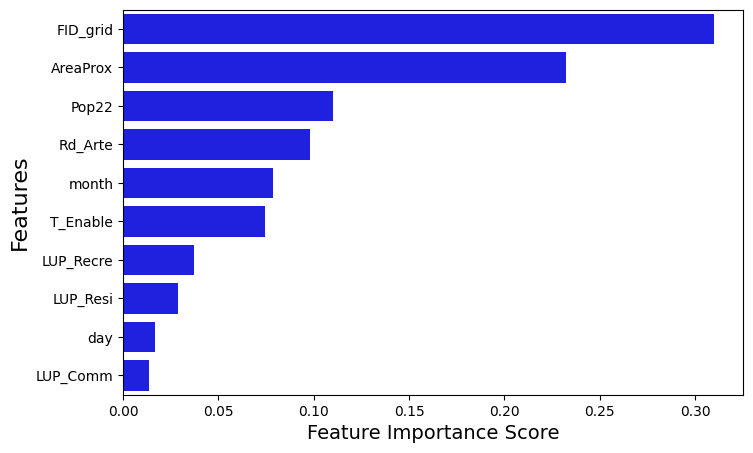

In [19]:
# Get feature importances and plot them
result1 = pd.DataFrame({"features":features_1, "importances":regressor.feature_importances_})
result = result1.sort_values(by='importances',ascending=False)
plt.figure(figsize=(8,4))
sns.barplot(x=result['importances'], y=result['features'], color='blue')
plt.xlabel('Feature Importance Score', fontsize='14')
plt.ylabel('Features', fontsize='16')
plt.rc('xtick', labelsize=12)
plt.rc('ytick', labelsize=12)

# Random Forest Model

In [20]:
from sklearn.ensemble import RandomForestRegressor
# Define the Random Forest model
rf = RandomForestRegressor()

# Fit the regressor to the training data
rf.fit(x_train, y_train)

# Predict on the test data
y_pred = rf.predict(x_test)

# Calculate mean squared error and R-squared score on the test data
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Print the metrics
print("Mean squared error: {:.2f}".format(mse))
print("R-squared score: {:.2f}".format(r2))

Mean squared error: 2371.07
R-squared score: 0.92


In [21]:
# Define the parameter grid
param_dist = {'n_estimators': [100, 150, 200, 250],
              'max_depth': list(np.arange(1, len(features_1), 2)),
              'max_features': list(np.arange(3, len(features_1), 2))}

# Run randomized search
random_search = RandomizedSearchCV(rf, param_distributions=param_dist, n_iter=100, cv=10, n_jobs=-1)

# Fit the model on the data
with tqdm(total=1) as pbar:
        random_search.fit(x_train, y_train)
        pbar.update(1)

# Print the best hyperparameters
print("Best Hyperparameters: ", random_search.best_params_)

  0%|                                                                                           | 0/10 [00:00<?, ?it/s]C:\Users\omkarp\AppData\Local\anaconda3\envs\omkarp\lib\site-packages\sklearn\model_selection\_search.py:285: UserWarning: The total space of parameters 80 is smaller than n_iter=100. Running 80 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
 10%|████████▏                                                                         | 1/10 [03:55<35:20, 235.63s/it]C:\Users\omkarp\AppData\Local\anaconda3\envs\omkarp\lib\site-packages\sklearn\model_selection\_search.py:285: UserWarning: The total space of parameters 80 is smaller than n_iter=100. Running 80 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
 20%|████████████████▍                                                                 | 2/10 [07:38<30:23, 227.92s/it]C:\Users\omkarp\AppData\Local\anaconda3\envs\omkarp\lib\site-packages\sklearn\model_selection\_search.py:285:

Best Hyperparameters:  {'n_estimators': 150, 'max_features': 9, 'max_depth': 9}


In [23]:
# Define the best hyperparameters found by GridSearchCV
best_params = {'max_depth': 9, 'max_features': 9, 'n_estimators': 150}

# Create a random forest regressor with the best hyperparameters
rf = RandomForestRegressor(**best_params, random_state=42)

# Fit the regressor to the training data
rf.fit(x_train, y_train)

# Predict on the test data
y_pred = rf.predict(x_test)

# Calculate mean squared error and R-squared score on the test data
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Print the metrics
print("Mean squared error: {:.2f}".format(mse))
print("R-squared score: {:.2f}".format(r2))
print(f"RMSE: {rmse:.2f}")
# mean_score = np.mean(scores)
#scores = cross_val_score(rf, X, y, cv=10, scoring='r2')
# print(f"Mean cross-validation R2: {mean_score:.2f}")

Mean squared error: 4237.26
R-squared score: 0.85
RMSE: 36.26


In [32]:
# Perform 10-fold cross-validation
cv_results = cross_validate(rf, X, y, cv=10, scoring='r2', return_estimator=True)

# Extract the estimators from each fold
estimators = cv_results['estimator']

# Calculate the R2 score for each fold using the test data
test_scores = []
for i, estimator in enumerate(estimators):
    y_pred = estimator.predict(x_test)
    score = r2_score(y_test, y_pred)
    test_scores.append(score)
    print(f"Fold {i+1} R2 score: {score:.2f}")

# Print the average R2 score across all folds for the test data
print(f"Mean test R2 score: {np.mean(test_scores):.2f}")

Fold 1 R2 score: 0.86
Fold 2 R2 score: 0.87
Fold 3 R2 score: 0.85
Fold 4 R2 score: 0.87
Fold 5 R2 score: 0.85
Fold 6 R2 score: 0.45
Fold 7 R2 score: 0.78
Fold 8 R2 score: 0.86
Fold 9 R2 score: 0.87
Fold 10 R2 score: 0.86
Mean test R2 score: 0.81


In [24]:
# get the feature importances
importances = rf.feature_importances_
print(features_1, importances)

['Pop22', 'Rd_Arte', 'AreaProx', 'FID_grid', 'month', 'day', 'T_Enable', 'LUP_Recre', 'LUP_Resi', 'LUP_Comm'] [0.20145328 0.07162819 0.21268805 0.22390375 0.23272043 0.02560797
 0.01020491 0.01516259 0.00282831 0.00380251]


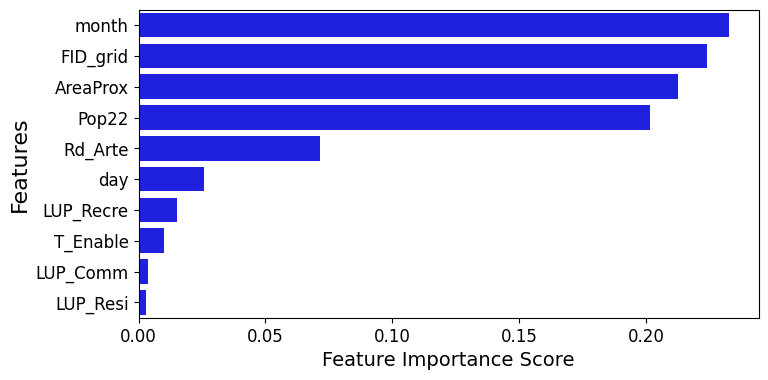

In [26]:
# Get feature importances and plot them
result1 = pd.DataFrame({"features":features_1, "importances":rf.feature_importances_})
result = result1.sort_values(by='importances',ascending=False)
plt.figure(figsize=(8,4))
sns.barplot(x=result['importances'], y=result['features'], color='blue')
plt.xlabel('Feature Importance Score', fontsize='14')
plt.ylabel('Features', fontsize='16')
plt.rc('xtick', labelsize=12)
plt.rc('ytick', labelsize=12)

**Comparative stats**

**XG-Boost Model** 
- mse:  1315.0647460923954
- Mean cross-validation R2: 0.93
- RMSE: 36.263821
- R_squared score : 0.976761

**Random Forest Model**
- MSE: 4237.26
- Mean cross-validation R2: 0.81
- RMSE: 36.26
- R-squared score: 0.85